In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class HeartDiseasePreprocessor:
    """
    Comprehensive preprocessing pipeline for Heart Disease UCI dataset
    """
    
    def __init__(self):
        self.scaler = None
        self.label_encoders = {}
        self.imputer = None
        self.feature_names = None
        self.categorical_features = []
        self.numerical_features = []
        
    def load_data(self):
        """
        Load the Heart Disease UCI dataset using ucimlrepo
        """
        try:
            from ucimlrepo import fetch_ucirepo
            
            # Fetch dataset
            heart_disease = fetch_ucirepo(id=45)
            
            # Get features and target
            X = heart_disease.data.features
            y = heart_disease.data.targets
            
            # Combine features and target
            df = pd.concat([X, y], axis=1)
            
            print("✅ Dataset loaded successfully using ucimlrepo!")
            print(f"Dataset shape: {df.shape}")
            return df
            
        except ImportError:
            print("⚠️  ucimlrepo not available. Loading from URL...")
            return self.load_data_from_url()
    
    def load_data_from_url(self):
        """
        Alternative method to load data from direct URL
        """
        # Cleveland dataset (most commonly used)
        url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
        
        # Column names based on UCI documentation
        column_names = [
            'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
            'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
        ]
        
        # Load data
        df = pd.read_csv(url, names=column_names, na_values='?')
        
        print("✅ Dataset loaded from URL!")
        print(f"Dataset shape: {df.shape}")
        return df
    
    def basic_info(self, df):
        """
        Display basic information about the dataset
        """
        print("\n" + "="*50)
        print("📊 DATASET OVERVIEW")
        print("="*50)
        
        print(f"Dataset Shape: {df.shape}")
        print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")
        
        print("\n📋 Column Information:")
        print("-" * 30)
        for col in df.columns:
            dtype =str(df[col].dtype)
            null_count = df[col].isnull().sum()
            null_pct = (null_count / len(df)) * 100
            unique_count = df[col].nunique()
            print(f"{col:12} | {dtype:8} | {null_count:3} nulls ({null_pct:5.1f}%) | {unique_count:3} unique")
        
        print("\n📈 Statistical Summary:")
        print("-" * 30)
        display(df.describe(include='all'))
        
        return df.info()
    
    def identify_feature_types(self, df):
        """
        Identify categorical and numerical features
        """
        # Based on UCI documentation, these are categorical
        categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
        
        # Numerical features
        numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
        
        # Target variable
        target = 'num'
        
        self.categorical_features = categorical_features
        self.numerical_features = numerical_features
        
        print(f"\n🏷️  Categorical Features ({len(categorical_features)}): {categorical_features}")
        print(f"🔢 Numerical Features ({len(numerical_features)}): {numerical_features}")
        print(f"🎯 Target Variable: {target}")
        
        return categorical_features, numerical_features, target
    
    def handle_missing_values(self, df, strategy='median'):
        """
        Handle missing values in the dataset
        
        Parameters:
        - strategy: 'median', 'mean', 'mode', 'knn', or 'drop'
        """
        print("\n" + "="*50)
        print("🔧 HANDLING MISSING VALUES")
        print("="*50)
        
        # Display missing value information
        missing_info = df.isnull().sum()
        missing_pct = (missing_info / len(df)) * 100
        
        missing_df = pd.DataFrame({
            'Column': missing_info.index,
            'Missing Count': missing_info.values,
            'Missing Percentage': missing_pct.values
        })
        
        print("Missing Values Summary:")
        print(missing_df[missing_df['Missing Count'] > 0])
        
        if missing_info.sum() == 0:
            print("✅ No missing values found!")
            return df
        
        df_cleaned = df.copy()
        
        if strategy == 'drop':
            # Drop rows with missing values
            df_cleaned = df_cleaned.dropna()
            print(f"🗑️  Dropped {len(df) - len(df_cleaned)} rows with missing values")
            
        elif strategy == 'knn':
            # Use KNN imputation
            imputer = KNNImputer(n_neighbors=5)
            
            # Separate features for imputation
            features_to_impute = df_cleaned.select_dtypes(include=[np.number]).columns
            df_cleaned[features_to_impute] = imputer.fit_transform(df_cleaned[features_to_impute])
            print("🔄 Applied KNN imputation for numerical features")
            
        else:
            # Use SimpleImputer
            # For numerical features
            if self.numerical_features:
                num_imputer = SimpleImputer(strategy=strategy)
                df_cleaned[self.numerical_features] = num_imputer.fit_transform(df_cleaned[self.numerical_features])
                print(f"🔄 Applied {strategy} imputation for numerical features")
            
            # For categorical features (use mode)
            if self.categorical_features:
                cat_imputer = SimpleImputer(strategy='most_frequent')
                df_cleaned[self.categorical_features] = cat_imputer.fit_transform(df_cleaned[self.categorical_features])
                print("🔄 Applied mode imputation for categorical features")
        
        print(f"✅ Dataset shape after handling missing values: {df_cleaned.shape}")
        return df_cleaned
    
    def encode_categorical_features(self, df):
        """
        Encode categorical features using one-hot encoding and label encoding
        """
        print("\n" + "="*50)
        print("🏷️  ENCODING CATEGORICAL FEATURES")
        print("="*50)
        
        df_encoded = df.copy()
        
        # Convert target variable to binary (presence/absence of heart disease)
        if 'num' in df_encoded.columns:
            df_encoded['target'] = (df_encoded['num'] > 0).astype(int)
            df_encoded = df_encoded.drop('num', axis=1)
            print("🎯 Converted target to binary: 0 (no disease), 1 (disease present)")
        
        # One-hot encode categorical features
        categorical_to_encode = [col for col in self.categorical_features if col in df_encoded.columns]
        
        if categorical_to_encode:
            print(f"\n🔄 Applying one-hot encoding to: {categorical_to_encode}")
            
            # Get dummies for categorical features
            df_encoded = pd.get_dummies(df_encoded, columns=categorical_to_encode, 
                                       prefix=categorical_to_encode, drop_first=True)
            
            print(f"✅ Dataset shape after encoding: {df_encoded.shape}")
            
            # Display new columns created
            new_columns = [col for col in df_encoded.columns if any(cat in col for cat in categorical_to_encode)]
            print(f"📊 New encoded columns ({len(new_columns)}): {new_columns[:10]}{'...' if len(new_columns) > 10 else ''}")
        
        return df_encoded
    
    def scale_features(self, df, scaler_type='standard'):
        """
        Scale numerical features
        
        Parameters:
        - scaler_type: 'standard' or 'minmax'
        """
        print("\n" + "="*50)
        print("📏 SCALING FEATURES")
        print("="*50)
        
        df_scaled = df.copy()
        
        # Identify numerical columns (excluding target)
        numerical_cols = df_scaled.select_dtypes(include=[np.number]).columns
        if 'target' in numerical_cols:
            numerical_cols = numerical_cols.drop('target')
        
        if len(numerical_cols) == 0:
            print("⚠️  No numerical features found for scaling")
            return df_scaled
        
        # Choose scaler
        if scaler_type == 'minmax':
            scaler = MinMaxScaler()
            print("🔄 Using MinMaxScaler (0-1 range)")
        else:
            scaler = StandardScaler()
            print("🔄 Using StandardScaler (mean=0, std=1)")
        
        # Apply scaling
        df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])
        self.scaler = scaler
        
        print(f"✅ Scaled {len(numerical_cols)} numerical features")
        print(f"📊 Scaled features: {list(numerical_cols)}")
        
        return df_scaled
    
    def exploratory_data_analysis(self, df_original, df_processed):
        """
        Comprehensive EDA with visualizations
        """
        print("\n" + "="*70)
        print("📊 EXPLORATORY DATA ANALYSIS")
        print("="*70)
        
        # Set up the plotting environment
        plt.figure(figsize=(20, 15))
        
        # 1. Target Distribution
        plt.subplot(3, 4, 1)
        if 'target' in df_processed.columns:
            target_counts = df_processed['target'].value_counts()
            plt.pie(target_counts.values, labels=['No Disease', 'Disease'], autopct='%1.1f%%', 
                   colors=['lightblue', 'lightcoral'])
            plt.title('Target Distribution', fontsize=12, fontweight='bold')
        
        # 2. Age Distribution
        plt.subplot(3, 4, 2)
        if 'age' in df_original.columns:
            plt.hist(df_original['age'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
            plt.title('Age Distribution', fontsize=12, fontweight='bold')
            plt.xlabel('Age')
            plt.ylabel('Frequency')
        
        # 3. Gender Distribution
        plt.subplot(3, 4, 3)
        if 'sex' in df_original.columns:
            sex_counts = df_original['sex'].value_counts()
            plt.bar(['Female', 'Male'], sex_counts.values, color=['pink', 'lightblue'])
            plt.title('Gender Distribution', fontsize=12, fontweight='bold')
            plt.ylabel('Count')
        
        # 4. Chest Pain Type
        plt.subplot(3, 4, 4)
        if 'cp' in df_original.columns:
            cp_counts = df_original['cp'].value_counts()
            plt.bar(range(len(cp_counts)), cp_counts.values, color='lightgreen')
            plt.title('Chest Pain Type Distribution', fontsize=12, fontweight='bold')
            plt.xlabel('Chest Pain Type')
            plt.ylabel('Count')
        
        # 5. Resting Blood Pressure
        plt.subplot(3, 4, 5)
        if 'trestbps' in df_original.columns:
            plt.hist(df_original['trestbps'], bins=20, alpha=0.7, color='orange', edgecolor='black')
            plt.title('Resting Blood Pressure', fontsize=12, fontweight='bold')
            plt.xlabel('Blood Pressure (mm Hg)')
            plt.ylabel('Frequency')
        
        # 6. Cholesterol Levels
        plt.subplot(3, 4, 6)
        if 'chol' in df_original.columns:
            plt.hist(df_original['chol'], bins=20, alpha=0.7, color='yellow', edgecolor='black')
            plt.title('Cholesterol Distribution', fontsize=12, fontweight='bold')
            plt.xlabel('Cholesterol (mg/dl)')
            plt.ylabel('Frequency')
        
        # 7. Maximum Heart Rate
        plt.subplot(3, 4, 7)
        if 'thalach' in df_original.columns:
            plt.hist(df_original['thalach'], bins=20, alpha=0.7, color='red', edgecolor='black')
            plt.title('Max Heart Rate Distribution', fontsize=12, fontweight='bold')
            plt.xlabel('Max Heart Rate')
            plt.ylabel('Frequency')
        
        # 8. Exercise Induced Angina
        plt.subplot(3, 4, 8)
        if 'exang' in df_original.columns:
            exang_counts = df_original['exang'].value_counts()
            plt.bar(['No', 'Yes'], exang_counts.values, color=['lightgreen', 'lightcoral'])
            plt.title('Exercise Induced Angina', fontsize=12, fontweight='bold')
            plt.ylabel('Count')
        
        # 9. Correlation Heatmap (using a subset of features for clarity)
        plt.subplot(3, 4, 9)
        if len(self.numerical_features) > 0:
            corr_features = [col for col in self.numerical_features if col in df_original.columns]
            if 'num' in df_original.columns:
                corr_features.append('num')
            
            if len(corr_features) > 1:
                corr_matrix = df_original[corr_features].corr()
                sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                           square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
                plt.title('Correlation Matrix', fontsize=12, fontweight='bold')
        
        # 10. Box plot for Age vs Target
        plt.subplot(3, 4, 10)
        if 'age' in df_original.columns and 'num' in df_original.columns:
            target_binary = (df_original['num'] > 0).astype(int)
            data_for_box = [df_original[target_binary == 0]['age'], 
                           df_original[target_binary == 1]['age']]
            plt.boxplot(data_for_box, labels=['No Disease', 'Disease'])
            plt.title('Age vs Heart Disease', fontsize=12, fontweight='bold')
            plt.ylabel('Age')
        
        # 11. Cholesterol vs Target
        plt.subplot(3, 4, 11)
        if 'chol' in df_original.columns and 'num' in df_original.columns:
            target_binary = (df_original['num'] > 0).astype(int)
            data_for_box = [df_original[target_binary == 0]['chol'], 
                           df_original[target_binary == 1]['chol']]
            plt.boxplot(data_for_box, labels=['No Disease', 'Disease'])
            plt.title('Cholesterol vs Heart Disease', fontsize=12, fontweight='bold')
            plt.ylabel('Cholesterol (mg/dl)')
        
        # 12. Feature Importance (based on correlation with target)
        plt.subplot(3, 4, 12)
        if 'target' in df_processed.columns:
            # Calculate correlation with target
            numerical_in_processed = [col for col in df_processed.select_dtypes(include=[np.number]).columns 
                                    if col != 'target']
            if numerical_in_processed:
                correlations = df_processed[numerical_in_processed + ['target']].corr()['target'].drop('target')
                correlations = correlations.abs().sort_values(ascending=True)
                
                plt.barh(range(len(correlations)), correlations.values, color='purple', alpha=0.7)
                plt.yticks(range(len(correlations)), correlations.index)
                plt.title('Feature Correlation with Target', fontsize=12, fontweight='bold')
                plt.xlabel('Absolute Correlation')
        
        plt.tight_layout()
        plt.show()
        
        # Summary Statistics
        print("\n📈 SUMMARY STATISTICS")
        print("-" * 50)
        
        print(f"• Dataset has {len(df_original)} samples and {len(df_original.columns)} features")
        if 'num' in df_original.columns:
            disease_pct = ((df_original['num'] > 0).sum() / len(df_original)) * 100
            print(f"• {disease_pct:.1f}% of patients have heart disease")
        
        if 'age' in df_original.columns:
            print(f"• Average age: {df_original['age'].mean():.1f} years (range: {df_original['age'].min()}-{df_original['age'].max()})")
        
        if 'sex' in df_original.columns:
            male_pct = (df_original['sex'].sum() / len(df_original)) * 100
            print(f"• {male_pct:.1f}% are male patients")
        
        # Feature Engineering Suggestions
        print(f"\n🔧 PREPROCESSING SUMMARY")
        print("-" * 50)
        print(f"• Original shape: {df_original.shape}")
        print(f"• Processed shape: {df_processed.shape}")
        print(f"• Features created through encoding: {df_processed.shape[1] - df_original.shape[1]}")
        
    def preprocess_pipeline(self, missing_strategy='median', scaler_type='standard'):
        """
        Complete preprocessing pipeline
        """
        print("🚀 Starting Heart Disease Data Preprocessing Pipeline")
        print("=" * 70)
        
        # 1. Load Data
        df = self.load_data()
        
        # 2. Basic Information
        self.basic_info(df)
        
        # 3. Identify Feature Types
        self.identify_feature_types(df)
        
        # Store original data for EDA
        df_original = df.copy()
        
        # 4. Handle Missing Values
        df = self.handle_missing_values(df, strategy=missing_strategy)
        
        # 5. Encode Categorical Features
        df = self.encode_categorical_features(df)
        
        # 6. Scale Features
        df = self.scale_features(df, scaler_type=scaler_type)
        
        # 7. Exploratory Data Analysis
        self.exploratory_data_analysis(df_original, df)
        
        # 8. Final Dataset Info
        print("\n" + "="*70)
        print("✅ PREPROCESSING COMPLETE!")
        print("="*70)
        print(f"Final dataset shape: {df.shape}")
        print(f"Features: {list(df.columns)}")
        
        # 9. Prepare for modeling
        if 'target' in df.columns:
            X = df.drop('target', axis=1)
            y = df['target']
            
            print(f"\nFeatures (X): {X.shape}")
            print(f"Target (y): {y.shape}")
            print(f"Target distribution: {y.value_counts().to_dict()}")
            
            return X, y, df
        else:
            return df, None, df


🚀 Starting Heart Disease Data Preprocessing Pipeline
⚠️  ucimlrepo not available. Loading from URL...
✅ Dataset loaded from URL!
Dataset shape: (303, 14)

📊 DATASET OVERVIEW
Dataset Shape: (303, 14)
Memory Usage: 33.27 KB

📋 Column Information:
------------------------------
age          | float64  |   0 nulls (  0.0%) |  41 unique
sex          | float64  |   0 nulls (  0.0%) |   2 unique
cp           | float64  |   0 nulls (  0.0%) |   4 unique
trestbps     | float64  |   0 nulls (  0.0%) |  50 unique
chol         | float64  |   0 nulls (  0.0%) | 152 unique
fbs          | float64  |   0 nulls (  0.0%) |   2 unique
restecg      | float64  |   0 nulls (  0.0%) |   3 unique
thalach      | float64  |   0 nulls (  0.0%) |  91 unique
exang        | float64  |   0 nulls (  0.0%) |   2 unique
oldpeak      | float64  |   0 nulls (  0.0%) |  40 unique
slope        | float64  |   0 nulls (  0.0%) |   3 unique
ca           | float64  |   4 nulls (  1.3%) |   4 unique
thal         | float64  |   

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB

🏷️  Categorical Features (8): ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
🔢 Numerical Features (5): ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
🎯 Target Variable: num

🔧 HANDLING MISSING VALUE

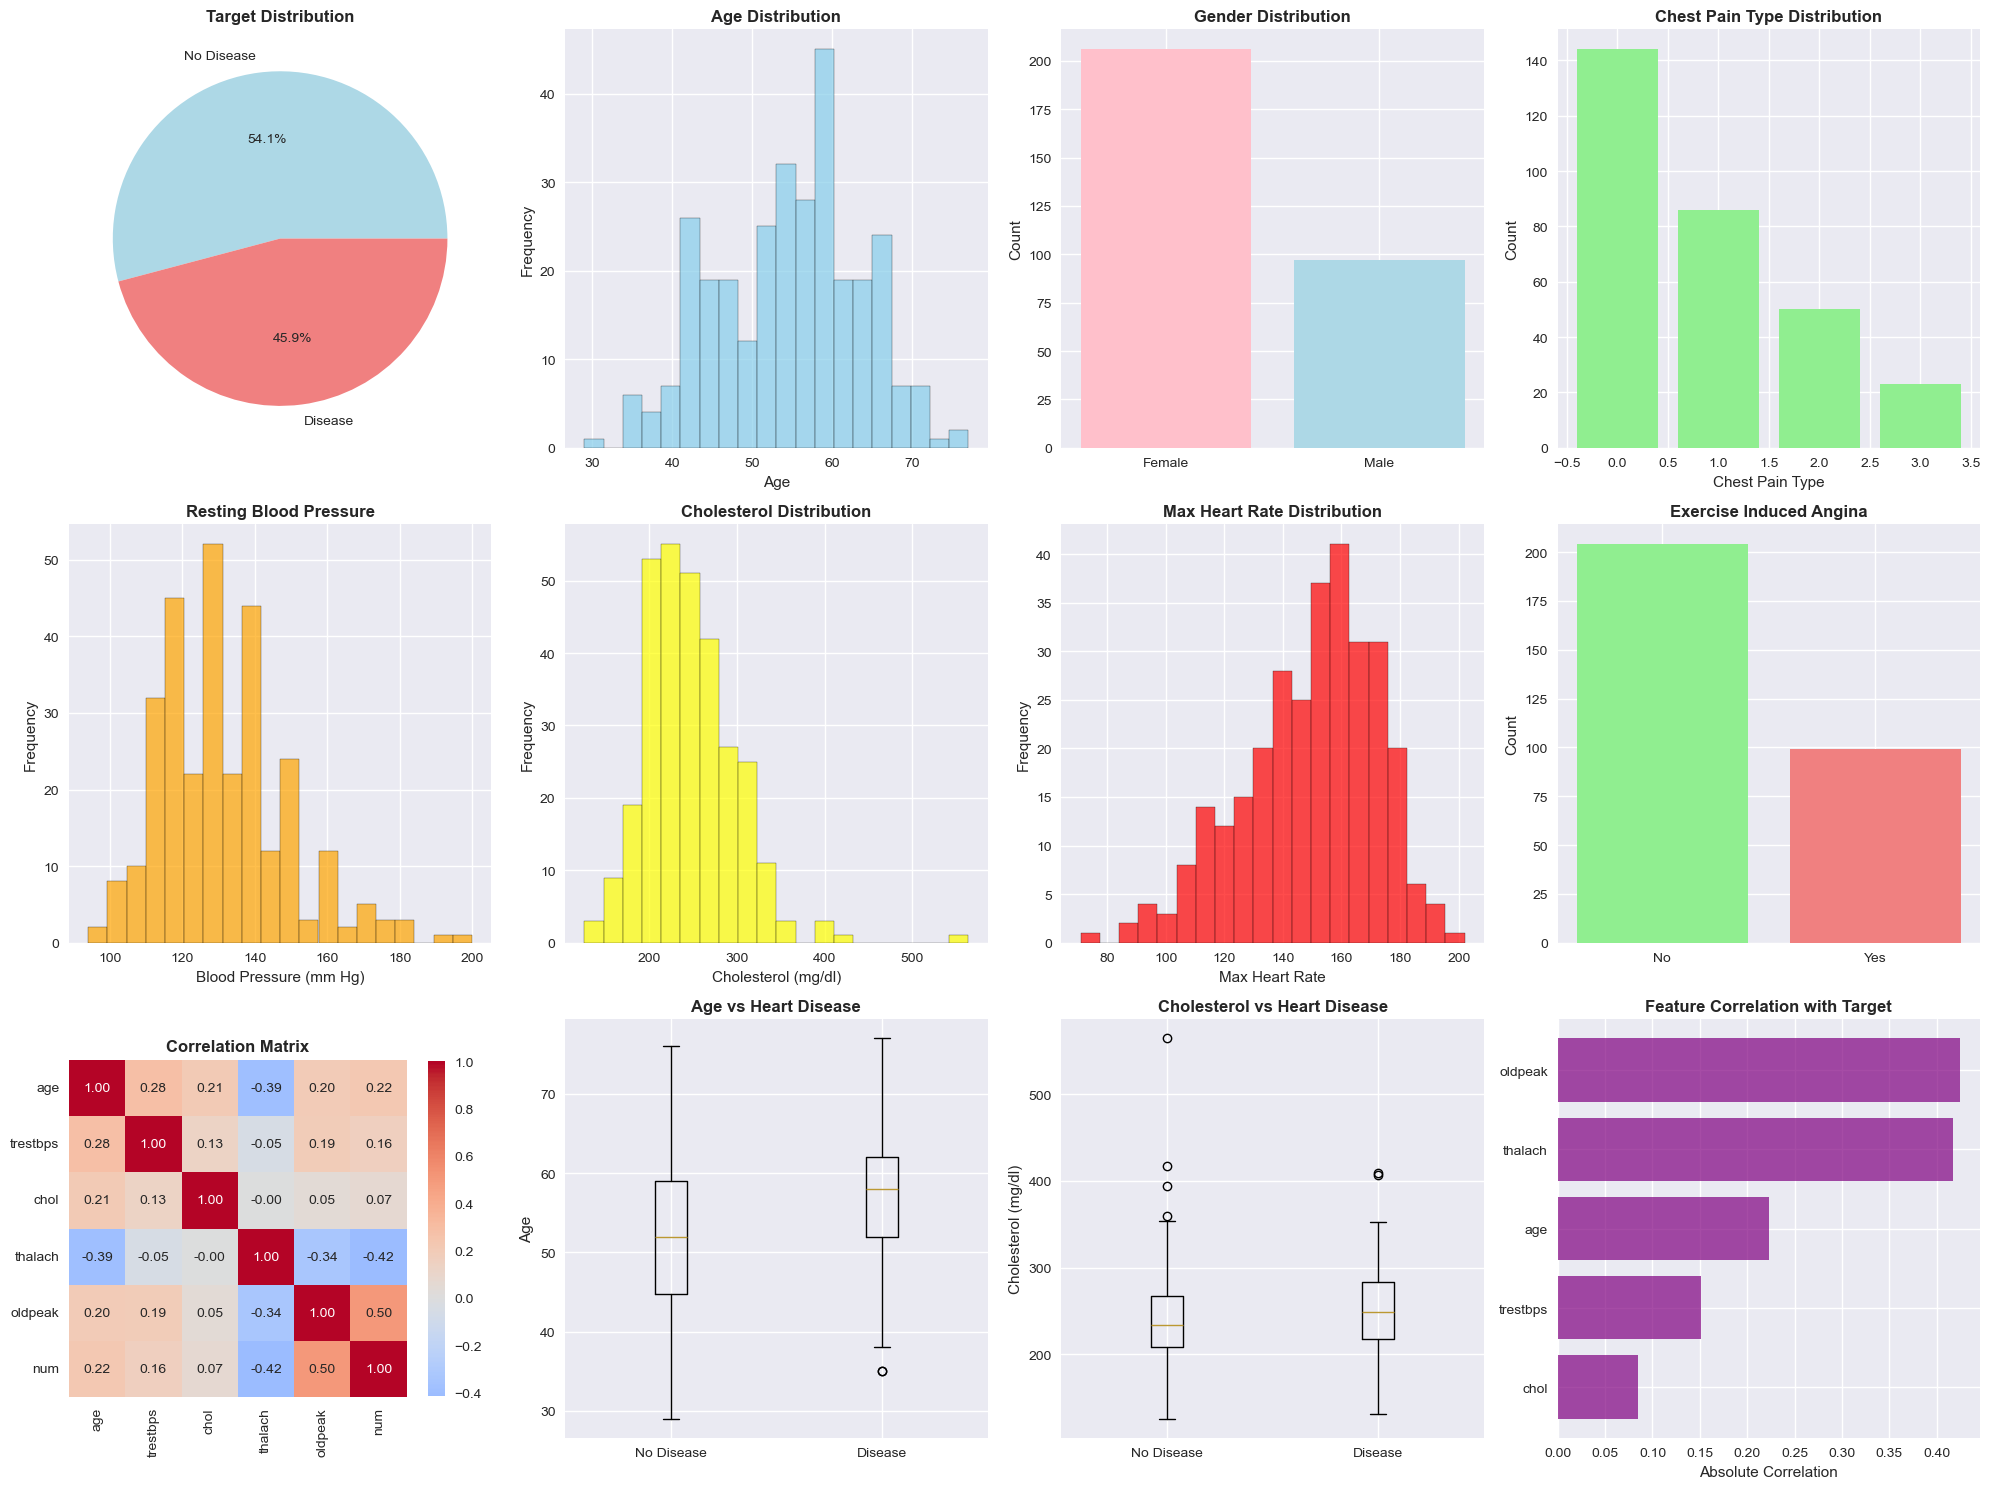


📈 SUMMARY STATISTICS
--------------------------------------------------
• Dataset has 303 samples and 14 features
• 45.9% of patients have heart disease
• Average age: 54.4 years (range: 29.0-77.0)
• 68.0% are male patients

🔧 PREPROCESSING SUMMARY
--------------------------------------------------
• Original shape: (303, 14)
• Processed shape: (303, 21)
• Features created through encoding: 7

✅ PREPROCESSING COMPLETE!
Final dataset shape: (303, 21)
Features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target', 'sex_1.0', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'fbs_1.0', 'restecg_1.0', 'restecg_2.0', 'exang_1.0', 'slope_2.0', 'slope_3.0', 'ca_1.0', 'ca_2.0', 'ca_3.0', 'thal_6.0', 'thal_7.0']

Features (X): (303, 20)
Target (y): (303,)
Target distribution: {0: 164, 1: 139}
✅ Data saved for modeling in 'model_ready_data.csv'


In [11]:
preprocessor = HeartDiseasePreprocessor()
X, y, processed_df = preprocessor.preprocess_pipeline()
processed_df.to_csv("model_ready_data.csv", index=False)
print("✅ Data saved for modeling in 'model_ready_data.csv'")